In [64]:
import pandas as pd

expedition_data = pd.read_csv("../datasets/EXPEDITION_DATA.csv", encoding='cp1252')
peaks_data = pd.read_csv("../datasets/PEAKS_DATA.csv")

merged_data = pd.merge(left=expedition_data, right=peaks_data, how='inner', on='PEAKID')

In [65]:
merged_data.loc[:, 'TOTALDEATHS'] = merged_data['MDEATHS'] + merged_data['HDEATHS']
merged_data.loc[:, 'SUCCESS'] =  merged_data['SUCCESS1'].astype(bool) | merged_data['SUCCESS2'].astype(bool)

In [66]:
df = merged_data[['PEAKID', 'EXPID', 'YEAR', 'SEASON', 'SEASON_FACTOR', 'HOST', 'HOST_FACTOR',
                  'ROUTE1', 'ROUTE2', 'ROUTE3', 'ROUTE4', 'TOTMEMBERS', 'TERMREASON_FACTOR', 'O2USED', 'O2NONE', 'NOHIRED',
                  'TOTALDEATHS', 'PKNAME', 'PKNAME2', 'HEIGHTM', 'HEIGHTF', 'HIMAL_FACTOR',
                  'REGION_FACTOR', 'OPEN', 'PYEAR', 'PSTATUS_FACTOR', 'PSMTDATE']]

In [67]:
df['PKNAME'].unique()

array(['Everest', 'Ama Dablam', 'Baruntse', 'Cho Oyu', 'Gyalzen Peak',
       'Himlung Himal', 'Kyungka Ri 2', 'Luza', 'Manaslu', 'Annapurna I',
       'Dhaulagiri I', 'Kangchung Shar', 'Lhotse', 'Makalu', 'Pumori',
       'Tilicho', 'Tengkangpoche', 'Tukuche', 'Annapurna III', 'Chamlang',
       'Chekigo', 'Chobuje', 'Cholatse', 'Dolma Khang', 'Dorje Lhakpa',
       'Gyajikang', 'Jannu', 'Kangchenjunga', 'Kangtega', 'Langdung',
       'Mariyang', 'Omitso Go', 'Omoga Ri Chang', 'Panbari',
       'Purbung Himal', 'Purkhung', 'Putha Hiunchuli', 'Rokapi',
       'Surma-Sarovar North', 'Tengkoma', 'Amphu Gyabjen', 'Annapurna IV',
       'Dorje Lakpa II', 'Gangapurna', 'Kangchung Nup', 'Nuptse East I',
       'Nuptse', 'Phu Kang', 'Pokharkang', 'Ratna Chuli', 'Saula',
       'Tengi Ragi Tau South', 'Bhemdang Ri', 'Bhrikuti Shail',
       'Chandi Himal', 'Chukyima Go', 'Chumbu', 'Chulu West',
       'Dhaulagiri II', 'Dogari', 'Ganchenpo', 'Hongku Chuli', 'Hongku',
       'Jannu East', 'Khatu

In [68]:
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score, recall_score, precision_score, f1_score, roc_auc_score,  roc_curve, confusion_matrix

In [69]:
features = ['PKNAME', 'O2USED', 'SEASON_FACTOR', 'NOHIRED']
target = 'SUCCESS'

X = df[features]
y = merged_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# target_encoder = TargetEncoder(cols=['PKNAME'])
# X_train_encoded = target_encoder.fit_transform(X_train, y_train)
# X_test_encoded = target_encoder.transform(X_test)

target_encoded_features = ['PKNAME']
onehot_encoded_features = ['SEASON_FACTOR']
numeric_features = ['O2USED', 'NOHIRED']

preprocessor = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(), target_encoded_features),
        ('onehot', OneHotEncoder(drop='first'), onehot_encoded_features),
    ],
    remainder='passthrough'
)

In [71]:
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression())
])

In [72]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [73]:
metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }

confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

print(metrics)

[[ 22  31]
 [ 15 109]]
{'Accuracy': 0.7401129943502824, 'Recall': 0.8790322580645161, 'Precision': 0.7785714285714286, 'F1': 0.8257575757575758}


In [74]:
y_probs = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
print(f"Probability of Success on test data: {y_probs[0]:.2f}")

Probability of Success on test data: 0.94


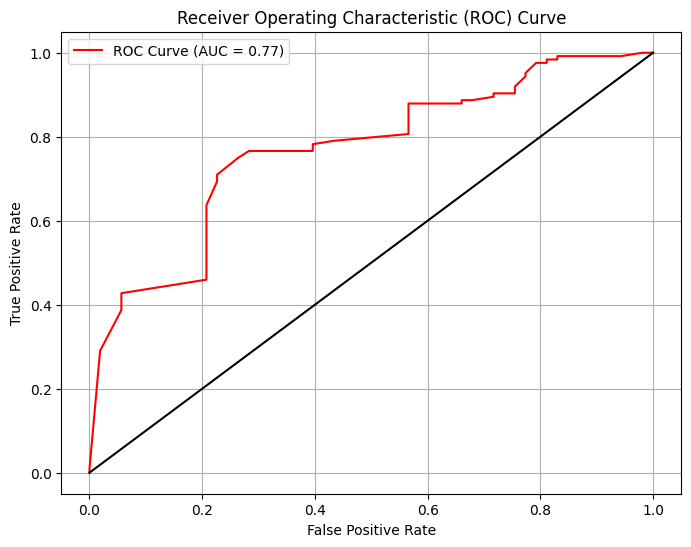

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='red')
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
from sklearn.model_selection import cross_validate

cv_scores = cross_validate(pipeline, X_train, y_train, cv=3, scoring='accuracy')
cv_scores

{'fit_time': array([0.02043152, 0.02137375, 0.02241898]),
 'score_time': array([0.00687313, 0.00708151, 0.00935268]),
 'test_score': array([0.77446809, 0.7787234 , 0.80425532])}

In [77]:
cv_scores = cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1')
cv_scores

{'fit_time': array([0.02263331, 0.02168536, 0.03718066]),
 'score_time': array([0.01141095, 0.01235914, 0.0087564 ]),
 'test_score': array([0.85399449, 0.85310734, 0.87078652])}

In [78]:
cv_scores = cross_validate(pipeline, X_train, y_train, cv=3, scoring='recall')
cv_scores

{'fit_time': array([0.02442598, 0.01978993, 0.02136159]),
 'score_time': array([0.01049089, 0.01080322, 0.00867414]),
 'test_score': array([0.92261905, 0.89880952, 0.92261905])}

In [79]:
cv_scores = cross_validate(pipeline, X_train, y_train, cv=3, scoring='precision')
cv_scores

{'fit_time': array([0.02273059, 0.02743483, 0.02336121]),
 'score_time': array([0.0119648 , 0.01079559, 0.01074839]),
 'test_score': array([0.79487179, 0.81182796, 0.82446809])}

In [106]:
input_data = {
    'PKNAME': ['Autumn'],
    'O2USED': [False],
    'SEASON_FACTOR': ['Summer'],
    'NOHIRED' : [False]
}

input_df = pd.DataFrame(input_data)

In [107]:
input_prediction = pipeline.predict(input_df)
input_prediction

array([ True])

In [108]:
input_prob = pipeline.predict_proba(input_df)[:, 1]
print(f"Probability of success: {input_prob[0]:.2f}")

Probability of success: 0.62


### **Saving Model and Encoder**

In [110]:
import joblib

joblib.dump(pipeline, 'saved_model_pipeline.pkl')

['saved_model_pipeline.pkl']